# Определение возраста покупателей

Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. 
Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Задача - построить модель для определения по фотографии приблизительного возраста человека. В вашем распоряжении набор фотографий людей с указанием возраста.

План проекта:
- Исследовательский анализ набора фотографий.
- Подготовка данных к обучению.
- Обучение нейронной сети и рассчет качества.

## Исследовательский анализ данных

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
                                dataframe=labels,
                                directory='/datasets/faces/final_files/',
                                x_col='file_name',
                                y_col='real_age',
                                target_size=(224, 224),
                                batch_size=32,
                                class_mode='raw',
                                seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

<AxesSubplot:>

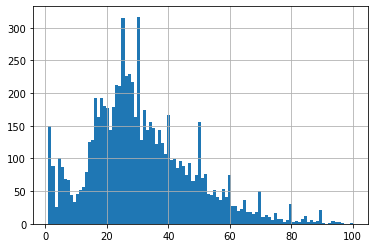

In [6]:
labels['real_age'].hist(bins=100)

В этом наборе данных представлены все возроста от 1 до 100 лет.  Чаще всеого встречается возраст  25   и 30 лет. Имеются всплески на "юбилейные" возраста. Наблюдается локальный минимум частоты к 10 годам. и логичное равномерно снижение частоты к 100 годам.

Распределение в целом похоже на нормальное.

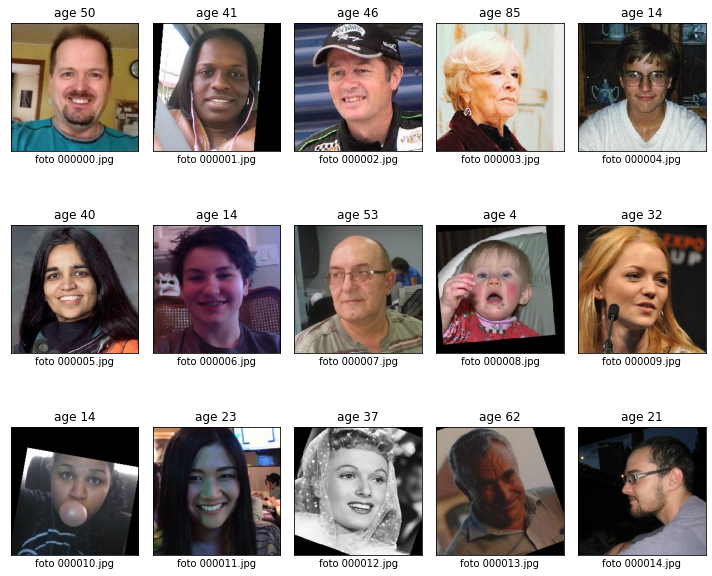

In [7]:
features, target = next(train_gen_flow)

# выводим 15 изображений
fig = plt.figure(figsize=(10,10))

for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('foto ' + str(labels['file_name'][i]))
    plt.tight_layout()
    plt.title('age ' + str(target[i]))


Данные содержат фото в различном исполнении и различного качества, имеются черно-белые фото и с фото с лицами под различным углом и посторонними предметами у лица. 

На мой взгляд - лучше бы конечно всё это поправить - так как в задаче описано что фотофиксация будет проводиться у кассы - где нормальное освещение - и человек будет направлен лицом в сторону кассира(в основном).

Размер лиц на фото также различается, но везде лицо взято крупным планом.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, Flatten, Dense, AvgPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd

def load_train(path):

    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(rescale=1./255 ,
                                       validation_split=0.20,
                                       horizontal_flip=True                                      
                                       )
                                       
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow
    
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')

    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.20)
                                       
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow
    
    
    
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(
                optimizer=optimizer, 
                loss='mse', 
                metrics=['mae'])
    return model
 

def train_model(model, train_data, test_data, batch_size=None,
                steps_per_epoch=None, validation_steps=None,
                verbose=2, epochs=20):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data = test_data,
              batch_size=batch_size,
              steps_per_epoch = steps_per_epoch,
              validation_steps = validation_steps,
              verbose=verbose, epochs=epochs)
    return model

```

## Анализ обученной модели

Использование нейросети с архитектурой ResNet c 50ю слоями позволило достичи не плохих резудьтатов метрики , без использования большого количества аугментаций и большого количества дополнительный слоёв.

нейронка на архитктуре ResNet очень мощный инструмент для анализа изображений  - благодаря применению применяет skip-connections, свёртки небольшого размера и bottleneck-слёв - которые уменьшают количество свойств в каждом слое, позволяющие экономить вычислительные ресурсы.

Веса инициализированны из большого датасета ImageNet на котором сеть предобучилась - это улучшит результат.

Чтобы адаптировать ResNet50 к нашей задаче верхушку сконструировали сами в ручную с функцией активации ReLu - возвращает значение х, если х положительно, и 0 в противном случае.(так как возраст не может быть отрицательным)

В качестве оптимизационного алгоритма применен Adam - он сочетает в себе и идею накопления движения и идею более слабого обновления весов для типичных признаков. Шаг обучения подобран равным 0.0005.

Модель возможно использовать для определения возростной группы для предложения товаров.
Но для задачи определения добросовестности кассиров при продаже алкоголя модель можно использовать приктически не возможно  - так как в России алкоголь разрешен с 18 лет а модель имеет ошибку  почти 7 лет, то есть вероятность что человеку в возрасте 17 лет модель даст как 10 лет так и 24 года.

Для достижения более высогоко показателя можно опробовать ResNet с большим количеством слоёв или более новые архитектуры произошетшие от идей ResNet  - такие как XResNet , ResNeXt, SE-ResNeXt, EfficientNet ...